<a href="https://colab.research.google.com/github/vm2781/adversarial_attacks/blob/main/Small_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data as DataUtils
import numpy as np
import time
import sys

# Readymade data loading function
DATA_ROOT='./MNISTData/'
def getMNISTDataLoaders(batchSize=64, nTrain=50000, nVal=10000, nTest=10000):
  # You can use technically use the same transform instance for all 3 sets
  assert (60000 - nVal) == nTrain, 'nTrain + nVal must be equal to 60000'
  trainTransform = transforms.Compose([transforms.ToTensor()])
  valTransform = transforms.Compose([transforms.ToTensor()])
  testTransform = transforms.Compose([transforms.ToTensor()])

  trainSet = datasets.MNIST(root=DATA_ROOT, download=True, train=True, \
                           transform=trainTransform)
  valSet = datasets.MNIST(root=DATA_ROOT, download=True, train=True, \
                         transform=valTransform)
  testSet = datasets.MNIST(root=DATA_ROOT, download=True, train=False, \
                                 transform=testTransform)

  indices = np.arange(0, 60000)
  np.random.shuffle(indices)

  trainSampler = SubsetRandomSampler(indices[:nTrain])
  valSampler = SubsetRandomSampler(indices[nTrain:])
  testSampler = SubsetRandomSampler(np.arange(0, nTest))

  trainLoader = DataUtils.DataLoader(trainSet, batch_size=batchSize, \
                                   sampler=trainSampler)
  valLoader = DataUtils.DataLoader(valSet, batch_size=batchSize, \
                                  sampler=valSampler)
  testLoader = DataUtils.DataLoader(testSet, batch_size=batchSize, \
                                    sampler=testSampler)
  return trainLoader, valLoader, testLoader

In [53]:
# Define the `device` PyTorch will be running on
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Notebook will use PyTorch Device: ' + device.upper())

Notebook will use PyTorch Device: CUDA


In [54]:
# Utility Progress Bar Function
def progress(curr, total, suffix=''):
  bar_len = 48
  filled = int(round(bar_len * curr / float(total)))
  if filled == 0:
    filled = 1
  bar = '=' * (filled - 1) + '>' + '-' * (bar_len - filled)
  sys.stdout.write('\r[%s] .. %s' % (bar, suffix))
  sys.stdout.flush()
  if curr == total:
    bar = bar_len * '='
    sys.stdout.write('\r[%s] .. %s .. Completed\n' % (bar, suffix))

In [55]:
###  Google Colab doesn't ship with advertorch and we will have to install it ourselves
# !pip install advertorch > /dev/null
# import advertorch
!pip install torchattack > /dev/null
from torchattack import PGD
import torchvision.models as models
import torch.nn as nn

# print(advertorch.__version__)

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import squeezenet1_0

class LeNet5(nn.Module):
    """
    LeNet-5 architecture for MNIST classification.
    Classic CNN designed for handwritten digit recognition.

    Architecture:
    - Input: 28x28 grayscale images
    - Conv1: 6 filters, 5x5 kernel
    - MaxPool: 2x2
    - Conv2: 16 filters, 5x5 kernel
    - MaxPool: 2x2
    - FC1: 120 units
    - FC2: 84 units
    - Output: 10 classes

    Total parameters: ~61k
    """

    def __init__(self):
        super(LeNet5, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Conv1: 28x28 -> 24x24
        x = F.relu(self.conv1(x))
        # MaxPool: 24x24 -> 12x12
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Conv2: 12x12 -> 8x8
        x = F.relu(self.conv2(x))
        # MaxPool: 8x8 -> 4x4
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten
        x = x.view(x.size(0), -1)  # (batch_size, 16*4*4)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

class SqueezeNetMNIST(nn.Module):
    """SqueezeNet adapted for MNIST by converting grayscale to RGB."""

    def __init__(self):
        super(SqueezeNetMNIST, self).__init__()
        base_model = squeezenet1_0(pretrained=False)
        # Replace final classifier to output 10 classes instead of 1000
        base_model.classifier[1] = nn.Conv2d(512, 10, kernel_size=1)
        self.model = base_model

    def forward(self, x):
        # Expand 1-channel to 3-channel by repeating
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        return self.model(x)

lenet_model = LeNet5()
robust_lenet_model = LeNet5()
squeezenet_model = SqueezeNetMNIST()
robust_squeezenet_model = SqueezeNetMNIST()

In [57]:
model_string = "squeezenet_robust2"
adv_model = robust_squeezenet_model

In [58]:
n_epochs = 10
lr = 1e-2
step = 0
xent_loss = nn.CrossEntropyLoss()
adv_model = adv_model.to(device)
adv_model.train()
optimizer = torch.optim.SGD(adv_model.parameters(), lr=lr)

train_loader, val_loader, test_loader = getMNISTDataLoaders()
start_time = time.time()

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import kagglehub
import pandas as pd
import os

def load_mnist_fgsm_dataloader(batch_size=32):
    # Download dataset
    path = kagglehub.dataset_download("sudulakishore/mnist-fgsm")

    # List files to find the test set
    files = os.listdir(path)
    print("Files available:", files)

    # Load the test file (adjust filename based on what you find)
    test_file = [f for f in files if 'test' in f.lower()][0]  # finds file with 'test' in name
    df = pd.read_csv(f"{path}/{test_file}")

    labels = df.iloc[:, -1].values
    images = df.iloc[:, :-1].values

    images_tensor = torch.tensor(images, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    images_tensor = images_tensor.reshape(-1, 1, 28, 28)

    dataset = TensorDataset(images_tensor, labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return dataloader
robust_eval_dataloader = load_mnist_fgsm_dataloader()

Using Colab cache for faster access to the 'mnist-fgsm' dataset.
Files available: ['mnist_test.csv', 'mnist_train.csv']


In [61]:
"""
Modified adversarial training using torchattack library.
Now trains on both original and adversarial examples for better robustness
while maintaining clean accuracy.
"""
loss_fn = nn.CrossEntropyLoss()
validation_reg_accuracy = []
validation_robust_accuracy = []
for i in range(n_epochs):
  for j, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)

    if 'robust' in model_string:
      adv_model.eval()  # Freeze model parameters
      adversary = PGD(adv_model, eps=0.3, steps=7, random_start=True)
      adv_images = adversary(images, labels)  # Generate adversarial samples

      # Unfreeze model parameters for training
      adv_model.train()

      train_images = torch.cat([images, adv_images], dim=0)
      train_labels = torch.cat([labels, labels], dim=0)

    else:
      adv_model.train()
      train_images = images
      train_labels = labels

    optimizer.zero_grad()
    logits = adv_model(train_images)
    loss = loss_fn(logits, train_labels)

    loss.backward()
    optimizer.step()

    if j % 8 == 0:
      progress(j+1, len(train_loader), 'Batch [{}/{}] Epoch [{}/{}] Loss = {:.3f}'.format(j+1, len(train_loader), i+1, n_epochs, loss.item()))

    step += 1
  val_correct = 0
  adv_model.eval()
  for(j, (images, labels)) in enumerate(val_loader):
    images, labels = images.to(device), labels.to(device)
    logits = adv_model(images)
    _, preds = torch.max(logits, 1)
    val_correct += (preds == labels).sum().item()
    progress(j+1, len(val_loader), 'Batch [{}/{}]'.format(j+1, len(val_loader)))
  print('Validation Accuracy = {}%\n'.format(float(val_correct) * 100 / 10000))
  validation_reg_accuracy.append(float(val_correct) * 100 / 10000)

  val_rob_correct = 0
  adv_model.eval()
  for(j, (images, labels)) in enumerate(robust_eval_dataloader):
    images, labels = images.to(device), labels.to(device)
    logits = adv_model(images)
    _, preds = torch.max(logits, 1)
    val_rob_correct += (preds == labels).sum().item()
    progress(j+1, 10000, 'Batch [{}/{}]'.format(j+1, 10000))
  print('Robust Validation Accuracy = {}%\n'.format(float(val_rob_correct) * 100 / 10000))
  validation_robust_accuracy.append(float(val_rob_correct) * 100 / 10000)


end_time = time.time()
print('\nTotal training steps = {}'.format(step))
print('Total time taken = {}'.format(end_time - start_time))

[================================================] .. Batch [157/157] .. Completed
Validation Accuracy = 49.47%

[=>----------------------------------------------] .. Batch [313/10000]Robust Validation Accuracy = 9.33%

[================================================] .. Batch [157/157] .. Completed
Validation Accuracy = 78.49%

[=>----------------------------------------------] .. Batch [313/10000]Robust Validation Accuracy = 12.29%

[================================================] .. Batch [157/157] .. Completed
Validation Accuracy = 91.1%

[=>----------------------------------------------] .. Batch [313/10000]Robust Validation Accuracy = 9.01%

[================================================] .. Batch [157/157] .. Completed
Validation Accuracy = 92.33%

[=>----------------------------------------------] .. Batch [313/10000]Robust Validation Accuracy = 8.72%

[================================================] .. Batch [157/157] .. Completed
Validation Accuracy = 91.14%

[=>----

In [62]:
model_string = "squeezenet_robust"

In [63]:
# LeNet Standard - 97.65%
# LeNet Robust - 95.4%
# SqueezeNet Standard - 98.44
# SqueezeNet Robust = 95.04%
correct = 0
adv_model.eval()
for j, (images, labels) in enumerate(test_loader):
  images, labels = images.to(device), labels.to(device)
  logits = adv_model(images)
  _, preds = torch.max(logits, 1)
  correct += (preds == labels).sum().item()
  progress(j+1, len(test_loader), 'Batch [{}/{}]'.format(j+1, len(test_loader)))
adv_model.train()
print('Accuracy = {}%'.format(float(correct) * 100 / 10000))

[================================================] .. Batch [157/157] .. Completed
Accuracy = 95.04%


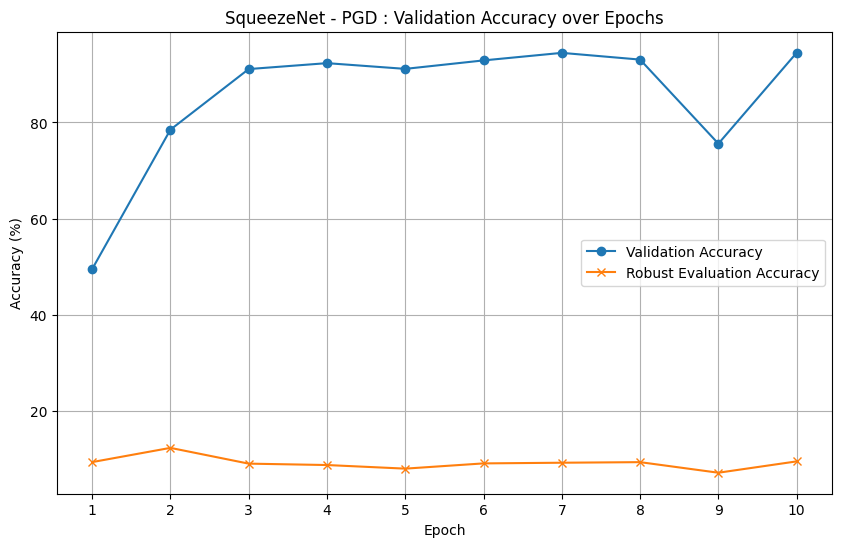

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), validation_reg_accuracy, label='Validation Accuracy', marker='o')
plt.plot(range(1, n_epochs + 1), validation_robust_accuracy, label='Robust Evaluation Accuracy', marker='x')

plt.title('SqueezeNet - PGD : Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.xticks(range(1, n_epochs + 1))
save_path = f'/content/drive/My Drive/adversarial_mnist/{model_string}.png'
plt.savefig(save_path, dpi=300, bbox_inches="tight")

In [65]:
from google.colab import drive
import os

drive.mount('/content/drive')

os.makedirs('/content/drive/My Drive/adversarial_mnist/all_saved_models', exist_ok=True)

torch.save(adv_model.state_dict(), f'/content/drive/My Drive/adversarial_mnist/all_saved_models/{model_string}.pth')
print("Model saved to Google Drive:" + f'/content/drive/My Drive/adversarial_mnist/all_saved_models/{model_string}.pth')

print("\nGoogle Drive structure created:")
print("  My Drive/")
print("    adversarial_mnist/")
print("      saved_models/")
print("      adversarial_examples/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to Google Drive:/content/drive/My Drive/adversarial_mnist/all_saved_models/squeezenet_robust.pth

Google Drive structure created:
  My Drive/
    adversarial_mnist/
      saved_models/
      adversarial_examples/


In [49]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    return total

le = LeNet5()
sq = SqueezeNetMNIST()

print(f"LeNet5 parameters: {count_parameters(le):,}")
print(f"SqueezeNet parameters: {count_parameters(sq):,}")

LeNet5 parameters: 44,426
SqueezeNet parameters: 740,554


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
